# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


filename_features = "./UCI HAR Dataset/features.txt"
filename_labels = "./UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "./UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "./UCI HAR Dataset/train/y_train.txt"

filename_subtest = "./UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "./UCI HAR Dataset/test/X_test.txt"
filename_ytest = "./UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#").squeeze()
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id']).squeeze()
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id']).squeeze()
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [7]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1 tBodyAcc-mean()-X,7352.0,0.274488,0.070261,-1.000000,0.262975,0.277193,0.288461,1.000000
2 tBodyAcc-mean()-Y,7352.0,-0.017695,0.040811,-1.000000,-0.024863,-0.017219,-0.010783,1.000000
3 tBodyAcc-mean()-Z,7352.0,-0.109141,0.056635,-1.000000,-0.120993,-0.108676,-0.097794,1.000000
4 tBodyAcc-std()-X,7352.0,-0.605438,0.448734,-1.000000,-0.992754,-0.946196,-0.242813,1.000000
5 tBodyAcc-std()-Y,7352.0,-0.510938,0.502645,-0.999873,-0.978129,-0.851897,-0.034231,0.916238
...,...,...,...,...,...,...,...,...
"557 angle(tBodyGyroMean,gravityMean)",7352.0,0.008726,0.608303,-1.000000,-0.482273,0.008735,0.506187,0.998702
"558 angle(tBodyGyroJerkMean,gravityMean)",7352.0,-0.005981,0.477975,-1.000000,-0.376341,-0.000368,0.359368,0.996078
"559 angle(X,gravityMean)",7352.0,-0.489547,0.511807,-1.000000,-0.812065,-0.709417,-0.509079,1.000000
"560 angle(Y,gravityMean)",7352.0,0.058593,0.297480,-1.000000,-0.017885,0.182071,0.248353,0.478157


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [8]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad  = pd.DataFrame(X_test).apply(padroniza, axis=0)

CPU times: total: 406 ms
Wall time: 390 ms


In [9]:
X_train_pad.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1 tBodyAcc-mean()-X,7352.0,-3.112007e-16,1.0,-18.139254,-0.163858,0.038502,0.198872,10.325905
2 tBodyAcc-mean()-Y,7352.0,4.735663e-17,1.0,-24.069884,-0.175631,0.011671,0.169379,24.937083
3 tBodyAcc-mean()-Z,7352.0,9.181387e-17,1.0,-15.729779,-0.209266,0.008206,0.200360,19.583956
4 tBodyAcc-std()-X,7352.0,-1.469022e-16,1.0,-0.879276,-0.863128,-0.759376,0.808108,3.577703
5 tBodyAcc-std()-Y,7352.0,7.731695e-18,1.0,-0.972726,-0.929466,-0.678330,0.948397,2.839333
...,...,...,...,...,...,...,...,...
"557 angle(tBodyGyroMean,gravityMean)",7352.0,-2.029570e-17,1.0,-1.658262,-0.807162,0.000015,0.817786,1.627440
"558 angle(tBodyGyroJerkMean,gravityMean)",7352.0,3.575909e-17,1.0,-2.079646,-0.774853,0.011743,0.764368,2.096467
"559 angle(X,gravityMean)",7352.0,9.278034e-17,1.0,-0.997354,-0.630155,-0.429596,-0.038163,2.910370
"560 angle(Y,gravityMean)",7352.0,-1.932924e-18,1.0,-3.558535,-0.257085,0.415080,0.637890,1.410395


### Análise de componentes principais (PCA) para a base de treinamento SEM padronização

In [10]:
%%time

pca = PCA()

princomp = pca.fit(X_train)

componentes = princomp.transform(X_train)

n_componentes = X_train.shape[1]

nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]

pd.DataFrame(data=componentes, columns=nomes_pca)

CPU times: total: 2.17 s
Wall time: 311 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,-1.863692e-17,-6.688803e-18,2.564021e-17,-7.595895e-17,-5.216399e-17,-4.603479e-15,-5.124190e-18,-1.920814e-16,-5.012719e-17,-1.827090e-16
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,3.733440e-17,7.964261e-17,1.441947e-17,-7.780166e-17,4.744228e-18,-9.692703e-16,-1.601365e-16,7.017444e-17,-5.102932e-17,-3.530071e-18
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-1.040978e-16,2.341527e-17,6.705717e-19,-9.650762e-18,3.121977e-17,1.582062e-16,-1.155911e-16,2.743651e-17,-1.349758e-16,-7.455234e-17
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,5.154205e-17,4.693473e-17,1.169899e-17,-9.249196e-17,-2.116820e-17,-6.558069e-16,-1.710321e-16,-4.129994e-17,-2.143350e-17,5.025563e-17
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,-7.947712e-18,5.775414e-17,2.531241e-17,-4.710023e-17,-1.064700e-17,8.567403e-16,1.273411e-16,8.448365e-17,-3.984932e-17,6.860970e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285,...,-7.100231e-17,-2.257785e-17,-1.530820e-17,5.772566e-17,1.055013e-16,2.375438e-15,1.579255e-16,1.977182e-16,9.931001e-18,-1.745041e-16
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650,...,-9.303638e-18,1.029615e-16,-2.973484e-17,1.925307e-16,7.407297e-17,-1.373968e-16,-2.736707e-17,1.699287e-16,-1.222800e-16,-1.340551e-16
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849,...,-1.018246e-16,1.713721e-16,-1.267111e-16,1.886506e-16,6.732296e-18,1.554779e-15,-3.042250e-16,-1.896234e-18,-2.928040e-16,-1.079090e-17
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171,...,-1.106801e-16,3.998467e-17,-3.116242e-17,1.247251e-16,7.161530e-18,-5.237077e-18,-6.583650e-17,1.949591e-16,-1.612346e-17,-3.445386e-17


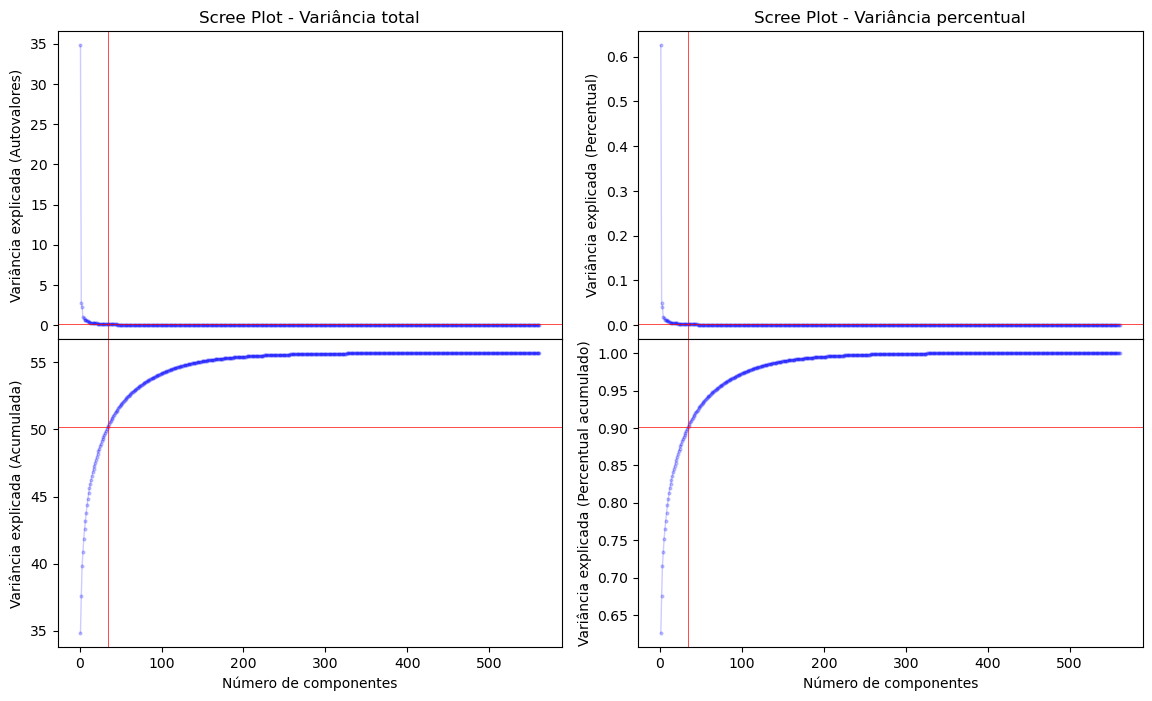

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 34 componentes.


In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

varexplicada = .90  
ncomp_criterio = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1

num_componentes = np.arange(princomp.n_components_) + 1
ax[0, 0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

ax[1, 0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

ax[0, 1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

ax[1, 1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

ax[0, 0].axhline(y=princomp.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')

In [12]:
variancia               = princomp.explained_variance_[ncomp_criterio - 1]
variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_criterio - 1]
pct_variancia           = princomp.explained_variance_ratio_[ncomp_criterio - 1]
pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_criterio - 1]

print(f'Número de componentes:...................... {ncomp_criterio}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes:...................... 34
Variância da última CP:..................... 0.13
Variância acumulada da última CP:........... 50.15
Variância percentual da última CP:.......... 0.24%
Variância percentual acumulada da última CP: 90.09%


In [13]:
pca_raw = pd.DataFrame(data={'variancia': princomp.explained_variance_[:ncomp_criterio], 
                             'variancia_acumulada': princomp.explained_variance_.cumsum()[:ncomp_criterio], 
                             'pct_variancia': princomp.explained_variance_ratio_[:ncomp_criterio], 
                             'pct_variancia_acumulada': princomp.explained_variance_ratio_.cumsum()[:ncomp_criterio]}, 
                       index=list(range(1, ncomp_criterio+1)))
pca_raw.index.name = 'CP'
pca_raw

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,34.823630,34.823630,0.625544,0.625544
2,2.735046,37.558677,0.049130,0.674675
3,2.294393,39.853070,0.041215,0.715889
4,1.043775,40.896845,0.018750,0.734639
5,0.943517,41.840362,0.016949,0.751587
6,0.708152,42.548514,0.012721,0.764308
7,0.655053,43.203567,0.011767,0.776075
8,0.595090,43.798657,0.010690,0.786765
9,0.539647,44.338304,0.009694,0.796459


### Análise de componentes principais (PCA) para a base de treinamento COM padronização

In [14]:
%%time

pca_pad = PCA()

princomp_pad = pca_pad.fit(X_train_pad)

componentes_pad = princomp_pad.transform(X_train_pad)

n_componentes_pad = X_train_pad.shape[1]

nomes_pca_pad = ['CP' + str(x+1) for x in list(range(n_componentes_pad))]

pd.DataFrame(data=componentes_pad, columns=nomes_pca_pad)

CPU times: total: 2.06 s
Wall time: 305 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,-2.877426e-17,1.507820e-16,5.057330e-16,1.576697e-16,2.459433e-16,4.299512e-16,2.480201e-16,7.151471e-17,-3.249031e-15,2.644737e-16
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,-5.834151e-17,-8.648626e-17,-4.236701e-17,1.473591e-16,9.250582e-17,9.867130e-17,4.940129e-18,2.241819e-16,1.272773e-15,-8.843470e-17
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,8.583491e-17,3.771851e-16,-1.225268e-16,1.964244e-16,9.604489e-17,-2.377673e-17,-1.269987e-16,-9.350986e-17,1.903783e-15,1.279437e-16
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,5.040539e-17,-4.379630e-17,2.594001e-16,2.056097e-16,1.926656e-16,-1.840405e-16,1.089899e-16,-2.667277e-16,-4.103104e-16,-2.775949e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,1.819778e-16,2.085300e-16,3.920517e-16,6.166840e-17,5.335343e-17,-6.393568e-17,-5.594515e-17,-2.675291e-16,1.537990e-15,-7.578023e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,15.464009,-12.535453,1.999041,3.457489,-1.523091,-2.698944,-3.561009,2.418529,0.383154,1.308633,...,4.466216e-17,-3.036248e-16,-5.591986e-16,-1.199335e-16,-1.742683e-16,-3.072286e-16,-1.776135e-17,-6.792032e-17,8.799504e-16,8.241647e-16
7348,14.221755,-10.252804,2.377499,2.802476,-1.325223,-4.345821,-2.193817,0.032138,-0.528893,0.702462,...,-1.879880e-16,-7.164401e-17,1.120092e-16,-1.873908e-16,-1.676646e-16,-2.563057e-16,1.477206e-16,-4.316650e-17,2.170584e-15,1.449226e-15
7349,14.332461,-12.259878,4.025672,3.849518,-2.860295,-3.623803,-3.929374,-0.873103,-0.746280,-1.575419,...,7.558693e-17,-3.291192e-16,-8.767181e-17,1.447688e-16,2.401621e-16,-3.493875e-16,3.110743e-17,1.899623e-16,1.194218e-15,7.621658e-16
7350,12.875143,-14.070299,2.915863,5.013085,-3.937957,-2.137461,-5.390033,0.321283,-0.916237,-1.646259,...,5.783240e-16,1.019283e-16,2.749605e-16,3.764947e-17,2.994440e-16,-1.246817e-16,-2.397695e-16,2.118736e-16,-2.526532e-15,1.108495e-16


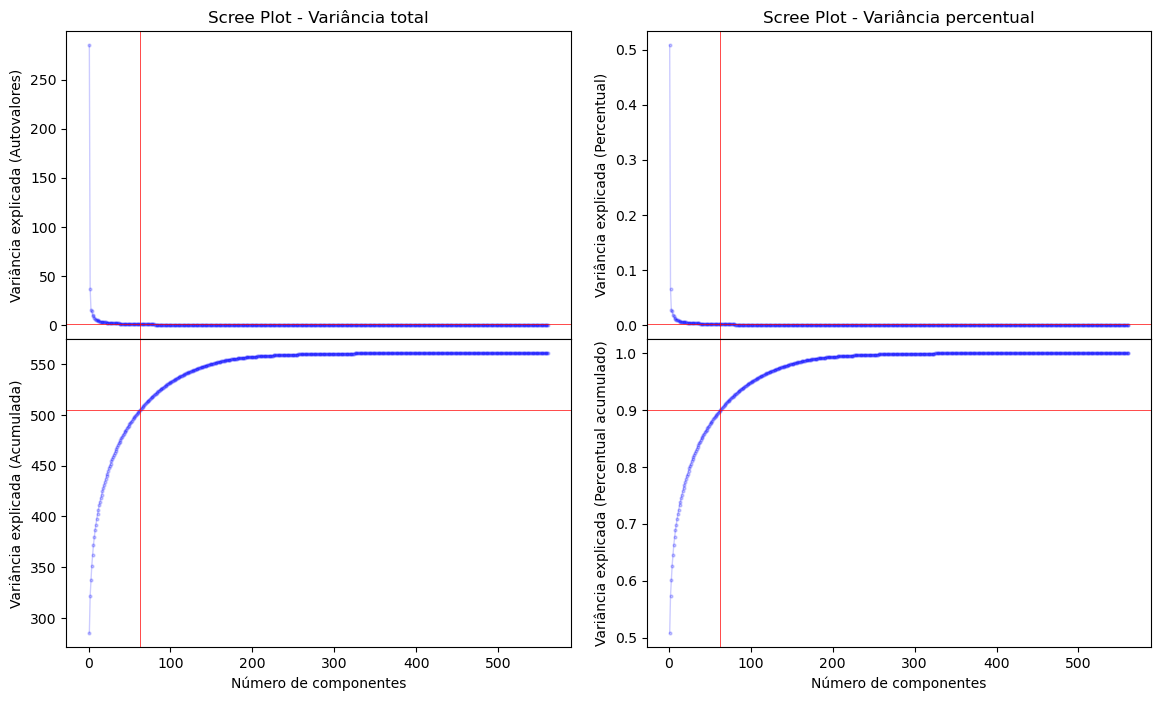

Para explicar 90% da variância com a padronização das variáveis, são necessárias 63 componentes.
Para o critério de autovalor > 1, são necessárias 61 componentes.


In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

varexplicada = .90
ncomp_criterio_pad = (princomp_pad.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1

num_componentes_pad = np.arange(princomp_pad.n_components_) + 1
ax[0, 0].plot(num_componentes_pad, princomp_pad.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

ax[1, 0].plot(num_componentes_pad, princomp_pad.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

ax[0, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

ax[1, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

ax[0, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)

ax[0, 0].axhline(y=princomp_pad.explained_variance_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp_pad.explained_variance_ratio_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância com a padronização das variáveis, são necessárias {ncomp_criterio_pad} componentes.')

criterio_autovalor = (princomp_pad.explained_variance_ratio_ > 1 / princomp_pad.n_components_).sum()
print(f'Para o critério de autovalor > 1, são necessárias {criterio_autovalor} componentes.')

In [16]:
variancia               = princomp_pad.explained_variance_[ncomp_criterio_pad - 1]
variancia_acumulada     = princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad - 1]
pct_variancia           = princomp_pad.explained_variance_ratio_[ncomp_criterio_pad - 1]
pct_variancia_acumulada = princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad - 1]

print(f'Número de componentes:...................... {ncomp_criterio_pad}')

print(f'Variância da última CP:..................... {variancia:.2f}')
print(f'Variância acumulada da última CP:........... {variancia_acumulada:.2f}')
print(f'Variância percentual da última CP:.......... {100*pct_variancia:.2f}%')
print(f'Variância percentual acumulada da última CP: {100*pct_variancia_acumulada:.2f}%')

Número de componentes:...................... 63
Variância da última CP:..................... 0.99
Variância acumulada da última CP:........... 505.20
Variância percentual da última CP:.......... 0.18%
Variância percentual acumulada da última CP: 90.05%


In [17]:
pca_pad = pd.DataFrame(data={'variancia': princomp_pad.explained_variance_[:ncomp_criterio_pad], 
                             'variancia_acumulada': princomp_pad.explained_variance_.cumsum()[:ncomp_criterio_pad], 
                             'pct_variancia': princomp_pad.explained_variance_ratio_[:ncomp_criterio_pad], 
                             'pct_variancia_acumulada': princomp_pad.explained_variance_ratio_.cumsum()[:ncomp_criterio_pad]}, 
                       index=list(range(1, ncomp_criterio_pad+1)))
pca_pad.index.name = 'CP'
pca_pad

,variancia,variancia_acumulada,pct_variancia,pct_variancia_acumulada
CP,,,,
1,284.882377,284.882377,0.507812,0.507812
2,36.917616,321.799993,0.065807,0.573619
3,15.744110,337.544103,0.028064,0.601683
4,14.047175,351.591278,0.025040,0.626722
5,10.593279,362.184557,0.018883,0.645605
...,...,...,...,...
59,1.055044,501.154215,0.001881,0.893323
60,1.044672,502.198886,0.001862,0.895185
61,1.018027,503.216914,0.001815,0.897000


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

### Árvore de decisão com base em dados não padronizados

In [18]:
%%time

prcomp = PCA(n_components=10).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

print(f'Dimensões da base de treinamento: {pc_treino.shape}')
print(f'Dimensões da base de teste: {pc_teste.shape}\n')

clf = DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(pc_treino, y_train)

print(f'Acurácia na base de treinamento: {clf.score(pc_treino, y_train)}')
print(f'Acurácia na base de teste: {clf.score(pc_teste, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8926822633297062
Acurácia na base de teste: 0.8242280285035629

CPU times: total: 2.03 s
Wall time: 285 ms


### Árvore de decisão com base em dados padronizados

In [19]:
%%time

prcomp_pad = PCA(n_components=10).fit(X_train_pad)

pc_treino_pad = prcomp_pad.transform(X_train_pad)
pc_teste_pad  = prcomp_pad.transform(X_test_pad)

print(f'Dimensões da base de treinamento: {pc_treino_pad.shape}')
print(f'Dimensões da base de teste: {pc_teste_pad.shape}\n')

clf_pad = DecisionTreeClassifier(ccp_alpha=0.001)
clf_pad.fit(pc_treino_pad, y_train)

print(f'Acurácia na base de treinamento: {clf_pad.score(pc_treino_pad, y_train)}')
print(f'Acurácia na base de teste: {clf_pad.score(pc_teste_pad, y_test)}\n')

Dimensões da base de treinamento: (7352, 10)
Dimensões da base de teste: (2947, 10)

Acurácia na base de treinamento: 0.8588139281828074
Acurácia na base de teste: 0.7740074652188667

CPU times: total: 1.78 s
Wall time: 251 ms


### Comparação de Classificadores por Matrizes de Confusão e Acurácia

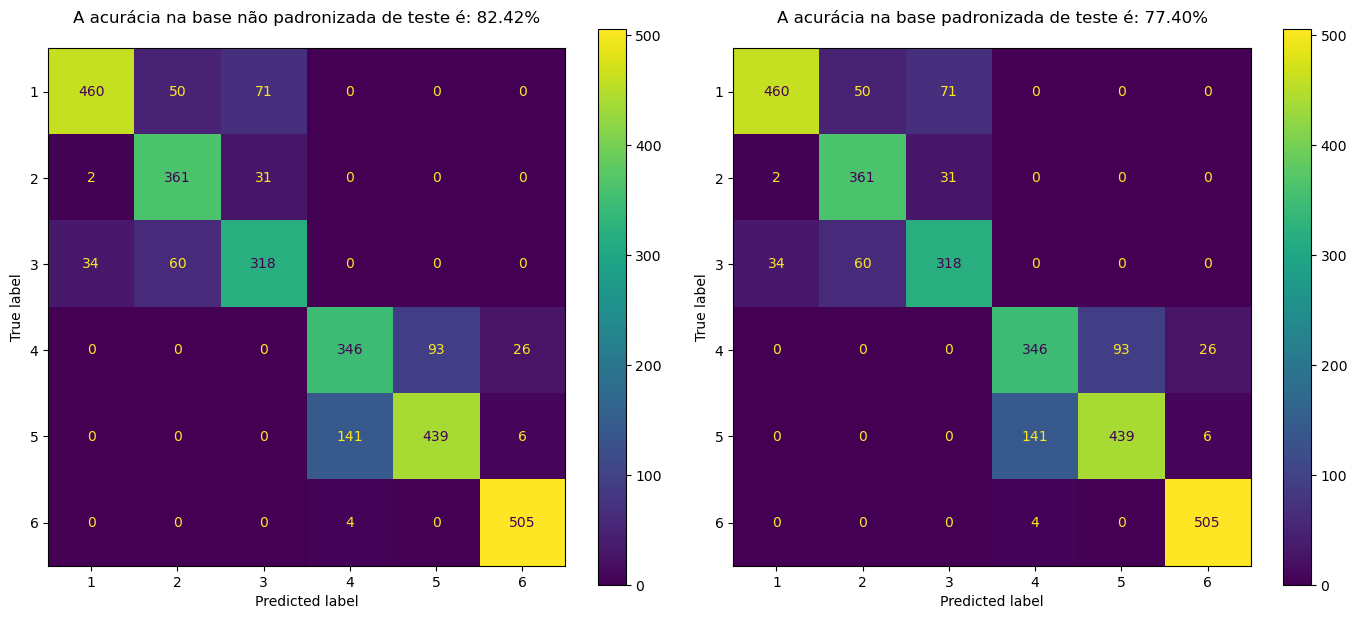

In [20]:
y_pred = clf.predict(pc_teste)
y_pred_pad = clf_pad.predict(pc_teste_pad)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax[0].set_title(f'A acurácia na base não padronizada de teste é: {accuracy_score(y_pred, y_test) * 100:.2f}%\n')

ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[0])

ax[1].set_title(f'A acurácia na base padronizada de teste é: {accuracy_score(y_pred_pad, y_test) * 100:.2f}%\n')

ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[1])

plt.tight_layout()

plt.show()